<a href="https://colab.research.google.com/github/apple2797/colab-1/blob/main/%E7%B6%B2%E9%A0%81%E7%88%AC%E8%9F%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#掛接雲端

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Google 美食圖片爬取


## 建立資料夾

In [ ]:
# -*- coding: utf-8 -*-
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from selenium.webdriver.common.keys import Keys
import pyautogui
from selenium.webdriver import ActionChains
from pynput.keyboard import Key, Controller
import pandas as pd
import requests
from selenium.webdriver.common.by import By
from pathlib import Path
import urllib
import os
def make_dir():
    ccco1 = ['西屯區']
    try:
        for skfd in range(len(ccco1)):
            dis_name = '台中'+ccco1[skfd]+'美食_data'
            dis_name1 = '台中'+ccco1[skfd]+'美食_images'
            os.mkdir(dis_name)
            os.mkdir(dis_name1)
    except:
        pass
make_dir() 

## 爬取連結

In [ ]:
ccco = ['西屯區']
for jie in range(len(ccco)):
    District = '台中'+ccco[jie]+'美食'
    def find_data():
        driver = webdriver.Chrome("C:\\Users\\user\\Desktop\\測試爬蟲\\chromedriver.exe")
        translation_a = urllib.parse.quote(District)
        driver.get('https://www.google.com.tw/maps/search/' + translation_a + '/@24.1623009,120.6227675,14z/data=!3m1!4b1?hl=zh-TW')
        for h in range(1, 3):
            element = driver.find_element_by_xpath('//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[1]/div[3]/div/a')
            actionChains = ActionChains(driver)
            actionChains.context_click(element).send_keys(Keys.ARROW_DOWN).perform()
            time.sleep(5)
            keyboard = Controller()
            keyboard.press(Key.esc)
            keyboard.release(Key.esc)
            time.sleep(3)
            for j in range(5):
                time.sleep(1)
                pyautogui.press('pgdn')
            #分析網頁
            soup = BeautifulSoup(driver.page_source)
            href1 = soup.find_all('a', {'class': 'hfpxzc'})
            href_link_list = []
            title_list = []
            for i in href1:
                href_link = i.get('href')
                title = i.get('aria-label')
                href_link_list.append(href_link)
                title_list.append(title)
            #print(href_link_list)
            #print(title_list)
            find_star = soup.find_all('span', {'class': 'ZkP5Je'})
            star_list = []
            for r in find_star:
                star_list.append(r.text.split('(')[0].replace(',', ''))
            print(star_list)
            #find_comm = soup.find_all('span', {'class': 'UY7F9'})
            comm_list = []
            for kk in find_star:
                try:
                    comm_list.append(kk.text.split('(')[1].replace(')', ''))
                except:
                    comm_list.append(kk.text.split('(')[0])
            print(comm_list)
            df = pd.DataFrame()
            df['店名'] = title_list
            df['網址'] = href_link_list
            df['星級'] = star_list
            df['評論'] = comm_list
            df.to_csv(District + '_data/' + str(h) + '商家網址連結.csv', index=False, encoding='utf-8-sig')
    find_data() 

## 爬取商家網址連結

In [ ]:
def marge_data():
    excel_dir = Path('C:\\Users\\user\\Desktop\\測試爬蟲\\'+ District+ '_data')
    excel_files = excel_dir.glob('*.csv')
    df = pd.DataFrame()
    for xls in excel_files:
        data = pd.read_csv(xls, sep=',' )
        df = df.append(data)
    df.to_csv(District+"_商家網址連結.csv", encoding='utf-8-sig', index=False, sep=',')
marge_data() 

## 篩選評論

In [ ]:
def select_data():
    df = pd.read_csv(District + '_商家網址連結.csv')
    df['評論'] = df['評論'].replace('沒有評論', '0')
    df['星級'] = df['星級'].replace('沒有評論', '0')
    df['評論'] = df['評論'].str.replace(',', '')
    df['星級'] = df[['星級']].astype(float)
    df['評論'] = df[['評論']].astype(int)
    df = df[(df["評論"] > 500) & (df["星級"] > 4.0)]
    df['回復'] = ''
    df['地址'] = ''
    df.to_csv(District + '_篩選評論.csv', encoding='utf-8-sig', index=False)
select_data()

##抓取留言

In [ ]:
def get_address():
    df = pd.read_csv(District + '_篩選評論.csv')
    link = list(df['網址'])
    for i in range(len(link)):
        driver = webdriver.Chrome("C:\\Users\\user\\Desktop\\測試爬蟲\\chromedriver.exe")
        driver.get(link[i])
        time.sleep(3)
        driver.find_element_by_xpath('//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[1]/div[1]').click()
        time.sleep(2)
        soup2 = BeautifulSoup(driver.page_source)
        address = soup2.find('div', {'class': 'Io6YTe fontBodyMedium'}).text
        time.sleep(3)
        for j in range(2):
            time.sleep(0.5)
            pyautogui.press('pgdn')
        time.sleep(3)
        soup1 = BeautifulSoup(driver.page_source)
        comm = soup1.find_all('div', {'class': 'tBizfc fontBodyMedium'})
        comm_list = []
        for ww in comm:
            comm_list.append(ww.text.replace(' 位評論者', '').replace('"', '').replace('   ', '').replace('  ', ''))
        print(comm_list)
        df.loc[i, '回復'] = str(comm_list)
        df.loc[i, '地址'] = str(address)
        df.to_csv(District + '_抓取留言.csv', encoding='utf-8-sig', index=False)
        time.sleep(2)
get_address()

##手動輸入篩選地址

In [ ]:
def select_address():
    df = pd.read_csv(District + '_抓取留言.csv')
    df = df[df['地址'].str.contains(ccco[jie], na=False)]
    df = df[~df['店名'].str.contains('公園', na=False)]
    df = df[~df['店名'].str.contains('車站', na=False)]
    df = df[~df['店名'].str.contains('后豐鐵馬道', na=False)]
    df = df[~df['店名'].str.contains('大甲鎮瀾宮', na=False)]
    df = df[~df['店名'].str.contains('大甲鐵砧山', na=False)]
    df = df[~df['店名'].str.contains('大肚藍色公路', na=False)]
    df = df[~df['店名'].str.contains('靜宜大學', na=False)]
    df = df[~df['店名'].str.contains('弘光科技大學', na=False)]
    df = df[~df['店名'].str.contains('東勢林場遊樂區', na=False)]
    df = df[~df['店名'].str.contains('東豐自行車綠廊', na=False)]
    df = df[~df['店名'].str.contains('高鐵台中站', na=False)]
    df = df[~df['店名'].str.contains('臺中國際展覽館', na=False)]
    df = df[~df['店名'].str.contains('醫院', na=False)]
    df = df[~df['店名'].str.contains('全聯福利中心', na=False)]
    df = df[~df['店名'].str.contains('麗寶Outlet Mall', na=False)]
    df = df[~df['店名'].str.contains('台中三井OUTLET摩天輪', na=False)]
    df = df[~df['店名'].str.contains('台中港旅客服務中心', na=False)]
    df = df[~df['店名'].str.contains('高美濕地', na=False)]
    df = df[~df['店名'].str.contains('牛罵頭遺址', na=False)]
    df = df[~df['店名'].str.contains('鰲峰山觀景平台', na=False)]
    df = df[~df['店名'].str.contains('臺中市港區藝術中心', na=False)]
    df = df[~df['店名'].str.contains('菩薩寺', na=False)]
    df = df[~df['店名'].str.contains('文化園區', na=False)]
    df = df.drop_duplicates(['店名', '地址'])
    df.to_csv(District + '_篩選地址.csv', encoding='utf-8-sig', index=False)
select_address()

##開始爬取圖片

In [ ]:
def get_image():
    df = pd.read_csv(District+'_篩選地址.csv')
    link = list(df['網址'])
    for i in range(len(link)):
            driver = webdriver.Chrome("C:\\Users\\user\\Desktop\\測試爬蟲\\chromedriver.exe")
            driver.get(link[i])
            time.sleep(3)
            driver.find_element_by_xpath('//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[1]/div[1]').click()
            time.sleep(3)
            for j in range(2):
                time.sleep(0.5)
                pyautogui.press('pgdn')
            time.sleep(3)
            soup1 = BeautifulSoup(driver.page_source)
            comm = soup1.find_all('div', {'class': 'goAFp-ShBeI-lvvS4b-RWgCYc'})
            comm_list = []
            for ww in comm:
                comm_list.append(ww.text.replace(' 位評論者', '').replace('"', '').replace('   ', '').replace('  ', ''))
            print(comm_list)
            df.loc[i, '回復'] = str(comm_list)
            df.to_csv(District+'_抓取留言.csv', encoding='utf-8-sig', index=False)
            time.sleep(2)
            for j in range(1):
                time.sleep(0.5)
                pyautogui.press('pgup')
            time.sleep(3)
            driver.find_element(By.XPATH, '//button[@aria-label="餐飲"]').click()
            time.sleep(2)
            driver.find_element_by_xpath('//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[3]/div[1]/div[2]/div/a/div[1]/div').click()
            time.sleep(2)
            for j in range(5):
                time.sleep(0.5)
                pyautogui.press('pgdn')
            time.sleep(3)
            soup = BeautifulSoup(driver.page_source)
            img = soup.find_all('div', {'class': 'U39Pmb'})
            ti = soup.find('div', {'class': 'piCU0 fontTitleLarge'}).text.replace('/', '').replace('|', '')
            img_list = []
            img_list1 = []
            for j in img:
                tes = j.get('style').strip('background-image').replace(': url("', '').replace('");', '').replace(':url(//:0)', '')
                print(tes)
                img_list.append(j.get('style').strip('background-image').replace(': url("', '').replace('");', '').replace(':url(//:0)', ''))
            for i in img_list:
                if len(i)>0:
                    img_list1.append(i)
            for p in range(len(img_list1)):
                img = requests.get(img_list1[p])
                with open(District+"_images\\" + str(ti) + str(p + 1) + ".jpg", "wb") as file:  # 開啟資料夾及命名圖片檔
                    file.write(img.content)
                file.close()
            print(img_list1)
            driver.close()
get_image()

##爬取結果

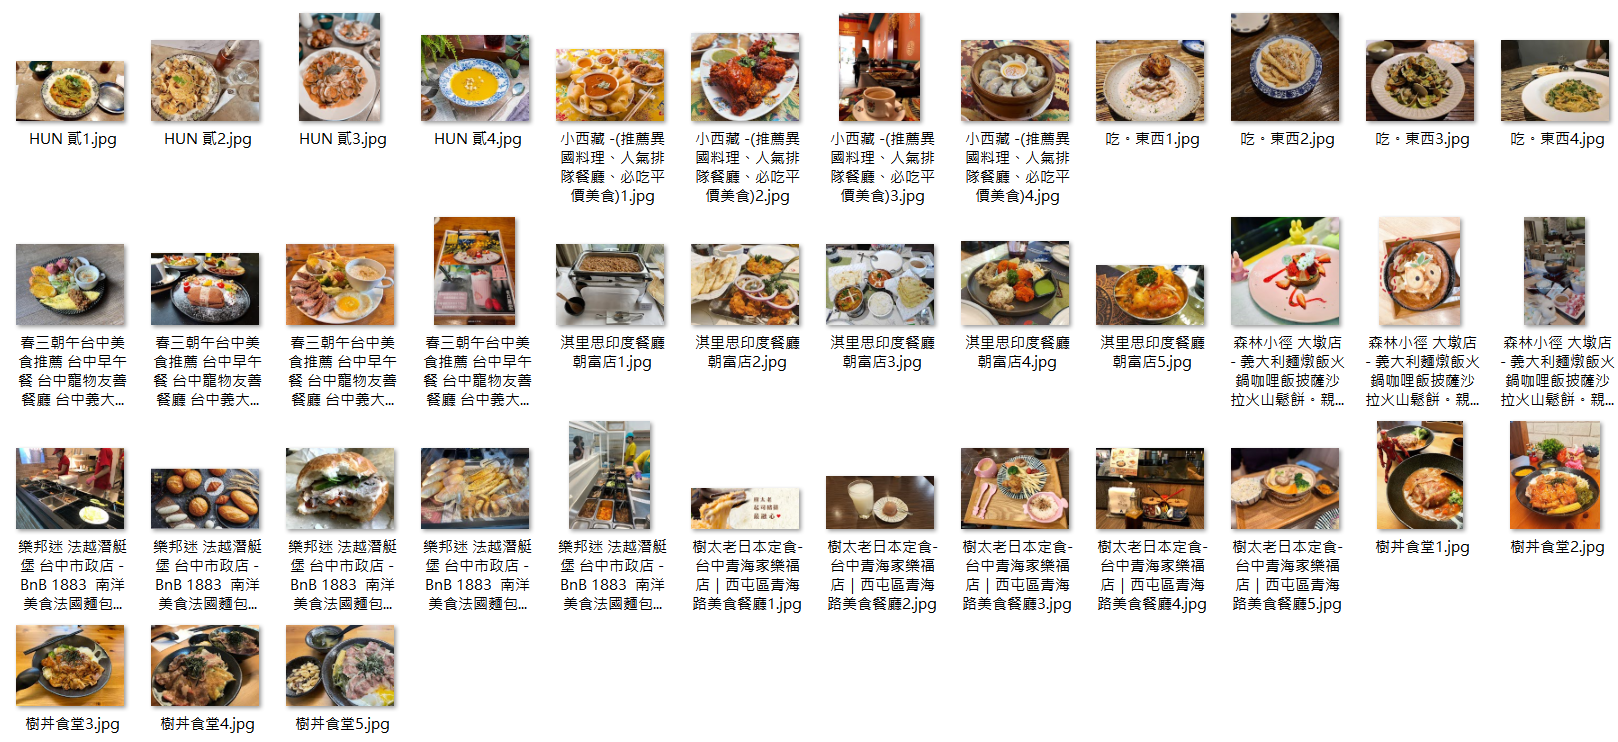

# FB 圖片爬取

##本地端爬取圖片

In [ ]:
from selenium.webdriver import Chrome
import time
import pyautogui
from bs4 import BeautifulSoup
import pandas as pd
import requests
# 設定exe檔位置
driver = Chrome("C:\\Users\\user\\Desktop\\測試爬蟲\\fb鞋子\\chromedriver.exe")
# 設定要開啟的網頁
driver.get("https://www.facebook.com/groups/740423979460595")
# 模擬滑鼠滾動
for j in range(10):
    time.sleep(0.5)
    pyautogui.press('pgdn') # 'pgdn'往下滑動作
time.sleep(3)
soup = BeautifulSoup(driver.page_source)
#print(soup)
posts = soup.find_all('img', class_='i09qtzwb n7fi1qx3 datstx6m pmk7jnqg j9ispegn kr520xx4 k4urcfbm bixrwtb6')
#print(posts)
#print(type(posts))-> <class 'bs4.element.ResultSet'>
posts_list=[]
posts1_list=[]
for i in posts:
    #print(i['src'])
    posts_list.append(i['src'])
    #print(i['src'])
posts1 = soup.find_all('img', class_='i09qtzwb n7fi1qx3 datstx6m pmk7jnqg j9ispegn kr520xx4 k4urcfbm')
#print(len(posts1))
for j in posts1:
    posts1_list.append(j['src'])
    #print(j['src'])
for p in range(len(posts_list)):
    img = requests.get(posts_list[p])
    with open('C:\\Users\\user\\Desktop\\測試爬蟲\\fb鞋子//' + str(p + 1) + ".jpg", "wb") as file:  # 開啟資料夾及命名圖片檔
        file.write(img.content)
for w in range(len(posts1_list)):
    img = requests.get(posts1_list[w])
    with open('C:\\Users\\user\\Desktop\\測試爬蟲\\fb鞋子//' +'0'+ str(w + 1) + ".jpg", "wb") as file:  # 開啟資料夾及命名圖片檔
        file.write(img.content)


#多圖：i09qtzwb n7fi1qx3 datstx6m pmk7jnqg j9ispegn kr520xx4 k4urcfbm
#單圖：i09qtzwb n7fi1qx3 datstx6m pmk7jnqg j9ispegn kr520xx4 k4urcfbm bixrwtb6

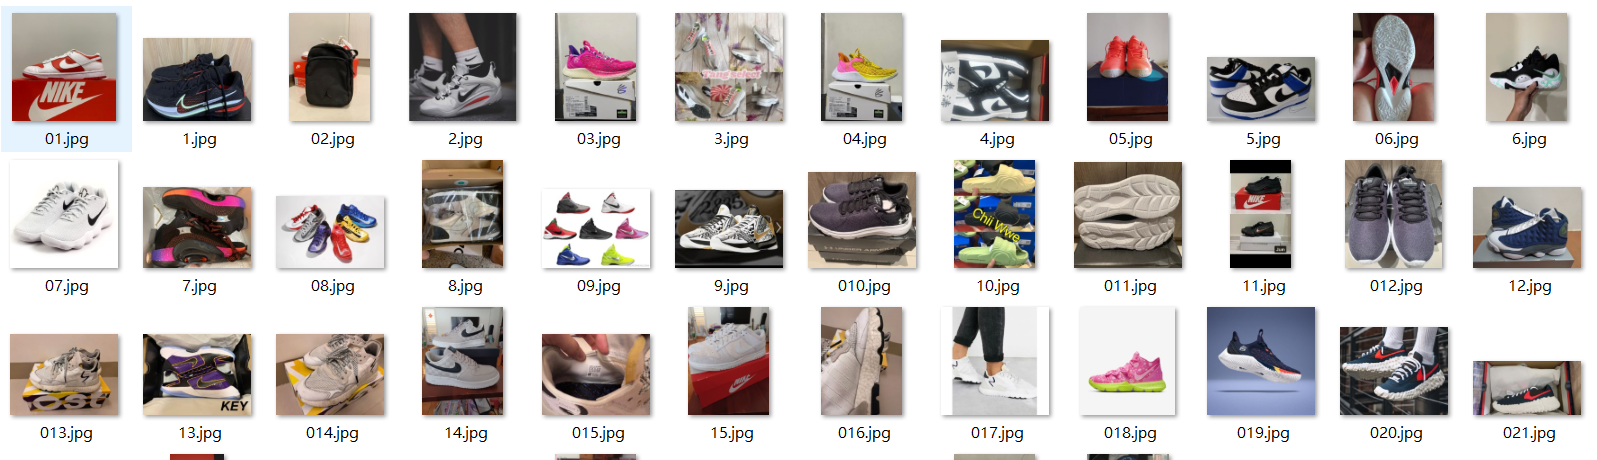

##讀取套件及檔案

In [ ]:
import cv2 as cv
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import os
import pandas as pd
import time
from PIL import Image

In [ ]:
path1 = '/content/drive/MyDrive/Colab Notebooks/履歷專案/鞋子爬蟲'
fileist1=os.listdir(path1)
print(len(fileist1))

20


##轉換圖片

In [ ]:
tStart = time.time()
path1 = '/content/drive/MyDrive/Colab Notebooks/履歷專案/鞋子爬蟲'
fileist=os.listdir(path1)
color_list = []
all_color_number = []
r_list = []
g_list = []
b_list = []
for i in fileist:
    img = cv.imread("/content/drive/MyDrive/Colab Notebooks/履歷專案/鞋子爬蟲/"+i)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    clt_1 = KMeans(n_clusters=3)
    clt_1.fit(img.reshape(-1, 3))
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)
    n_pixels = len(clt_1.labels_)
    counter = Counter(clt_1.labels_) # count how many pixels per cluster
    perc = {}
    for i in counter:
        perc[i] = np.round(counter[i]/n_pixels, 2)
    perc = dict(sorted(perc.items()))
    for w in clt_1.cluster_centers_:
        all_color_number.append(w)
    color_list1 = clt_1.cluster_centers_.tolist()
    color_list.append(color_list1)
df = pd.DataFrame()
df['name'] = fileist1
df['color'] = color_list
df.to_csv('/content/drive/MyDrive/Colab Notebooks/履歷專案/鞋子爬蟲/photo_to_colo1.csv',index=False, encoding='utf-8-sig')
try:
  os.mkdir('/content/drive/MyDrive/Colab Notebooks/履歷專案/鞋子爬蟲/hsv_color1')
except:
  pass
for j in all_color_number:
    r_list.append(int(j[0]))
    g_list.append(int(j[1]))
    b_list.append(int(j[2]))
for k in range(len(all_color_number)):
    im = Image.new("RGB",(64,48) ,(r_list[k], g_list[k],b_list[k]))  # RGB轉換成HSV顏色圖片
    im.save('/content/drive/MyDrive/Colab Notebooks/履歷專案/鞋子爬蟲/hsv_color1/'+str(k)+'.jpg')
tEnd = time.time()
print('finish')
print('所需花費秒數:'+str(tEnd-tStart))

finish
所需花費秒數:43.37905502319336


##讀取套件

In [ ]:
!pip uninstall opencv-python

Found existing installation: opencv-python 3.4.3.18
Uninstalling opencv-python-3.4.3.18:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-3.4.3.18.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-3.4.3.18


In [ ]:
!pip uninstall imgaug

Found existing installation: imgaug 0.2.5
Uninstalling imgaug-0.2.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.2.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.5


In [ ]:
!pip install imgaug==0.2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imgaug-0.2.5-py3-none-any.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires opencv-python, which is not installed.


In [ ]:
!pip install opencv-python==3.4.3.18

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached opencv_python-3.4.3.18-cp37-cp37m-manylinux1_x86_64.whl (25.0 MB)


In [ ]:
import cv2
import numpy as np
import collections
import os
import time
import pandas as pd

##顏色分類

In [ ]:
def getColorList():
    dict = collections.defaultdict(list)

    # 黑色
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 46])
    color_list = []
    color_list.append(lower_black)
    color_list.append(upper_black)
    dict['黑色'] = color_list

    # 灰色
    lower_gray = np.array([0, 0, 46])
    upper_gray = np.array([180, 43, 220])
    color_list = []
    color_list.append(lower_gray)
    color_list.append(upper_gray)
    dict['灰色']=color_list

    # 白色
    lower_white = np.array([0, 0, 221])
    upper_white = np.array([180, 30, 255])
    color_list = []
    color_list.append(lower_white)
    color_list.append(upper_white)
    dict['白色'] = color_list

    #紅色
    # lower_red = np.array([156, 43, 46])
    # upper_red = np.array([180, 255, 255])
    # color_list = []
    # color_list.append(lower_red)
    # color_list.append(upper_red)
    # dict['紅色']=color_list

    # 紅色2
    lower_red = np.array([0, 43, 46])
    upper_red = np.array([10, 255, 255])
    color_list = []
    color_list.append(lower_red)
    color_list.append(upper_red)
    dict['紅色'] = color_list

    #橙色
    lower_orange = np.array([11, 43, 46])
    upper_orange = np.array([25, 255, 255])
    color_list = []
    color_list.append(lower_orange)
    color_list.append(upper_orange)
    dict['橙色'] = color_list

    #黃色
    lower_yellow = np.array([26, 43, 46])
    upper_yellow = np.array([34, 255, 255])
    color_list = []
    color_list.append(lower_yellow)
    color_list.append(upper_yellow)
    dict['黃色'] = color_list

    #綠色
    lower_green = np.array([35, 43, 46])
    upper_green = np.array([77, 255, 255])
    color_list = []
    color_list.append(lower_green)
    color_list.append(upper_green)
    dict['綠色'] = color_list

    #青色
    lower_cyan = np.array([78, 43, 46])
    upper_cyan = np.array([99, 255, 255])
    color_list = []
    color_list.append(lower_cyan)
    color_list.append(upper_cyan)
    dict['青色'] = color_list

    #藍色
    lower_blue = np.array([100, 43, 46])
    upper_blue = np.array([124, 255, 255])
    color_list = []
    color_list.append(lower_blue)
    color_list.append(upper_blue)
    dict['藍色'] = color_list

    # 紫色
    lower_purple = np.array([125, 43, 46])
    upper_purple = np.array([155, 255, 255])
    color_list = []
    color_list.append(lower_purple)
    color_list.append(upper_purple)
    dict['紫色'] = color_list

    return dict

In [ ]:
tStart = time.time()
path = '/content/drive/MyDrive/Colab Notebooks/履歷專案/鞋子爬蟲/hsv_color1/'
fileist=os.listdir(path)
color_list = []
color_list1 =[]
for i in fileist:
    filename=path+i
    frame = cv2.imread(filename)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    maxsum = -100
    color = None
    color_dict = getColorList()
    for d in color_dict:
        mask = cv2.inRange(hsv,color_dict[d][0],color_dict[d][1])
        binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
        binary = cv2.dilate(binary,None,iterations=2)
        img, cnts, hiera = cv2.findContours(binary.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        sum = 0
        for c in cnts:
            sum+=cv2.contourArea(c)
        if sum > maxsum :
            maxsum = sum
            color = d
    color_list.append(color)
#print(color_list)
step=3
three_to_one_list = [color_list[i:i+step] for i in range(0,len(color_list),step)]
for k in three_to_one_list:
    color_list1.append(k)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/履歷專案/鞋子爬蟲/photo_to_colo1.csv')
df['hsv_color']= color_list1
df.to_csv('/content/drive/MyDrive/Colab Notebooks/履歷專案/鞋子爬蟲/photo_to_colo1.csv',index=False, encoding='utf-8-sig')
dict = {}
for key in color_list:
    dict[key] = dict.get(key, 0) + 1
print(dict)
tEnd = time.time()
print('finish')
print('所需花費秒數:'+str(tEnd-tStart))

{'灰色': 23, '紅色': 9, '黑色': 12, '藍色': 2, '黃色': 1, '橙色': 8, '紫色': 1, '白色': 4}
finish
所需花費秒數:0.2207014560699463


In [ ]:
dict

{'橙色': 8, '灰色': 23, '白色': 4, '紅色': 9, '紫色': 1, '藍色': 2, '黃色': 1, '黑色': 12}

#IG 圖片爬取

In [ ]:
from selenium.webdriver import Chrome
import time
# 設定exe檔位置
driver = Chrome("C:\\Users\\user\\Desktop\\測試爬蟲\\IG圖片\\chromedriver.exe")

# 設定要開啟的網頁
driver.get("https://www.instagram.com/accounts/login/")

# 等待時間(程式快，網路慢，要等)
time.sleep(2)

# 填寫帳號密碼
# 帳號
driver.find_element_by_name("username").send_keys("帳號")
# 密碼
driver.find_element_by_name("password").send_keys("密碼")

# 點擊登入
driver.find_element_by_xpath('//*[@id="loginForm"]/div/div[3]/button').click()
# 等待時間
time.sleep(5)
# 設定開啟戴資穎ig
driver.get("https://www.instagram.com/tai_tzuying/")
# 等待時間
time.sleep(5)

# 抓取圖片網址
from bs4 import BeautifulSoup
import requests

# 現學現賣BeautifulSoup再次登場
soup = BeautifulSoup(driver.page_source, 'html.parser')

# 找到圖片位置的第一層
find_path = soup.find_all('div','_aagu')
#print(find_path)
# 創建一個空的陣列裝需要的資料
path_list = []

# 往下找到需要的資料 div-img-src
for j in find_path:
  path = j.find('img').get('src')
  path_list.append(path)
  print(path)

#下載圖片
for w in range(len(path_list)):
  r = requests.get(path_list[w])
  with open('C:\\Users\\user\\Desktop\\測試爬蟲\\IG圖片\\pict//'+str(w)+'.jpg','wb') as f:
    f.write(r.content)

> 重要的兩段路徑

In [ ]:
# 設定exe檔位置
driver = Chrome("C:\\Users\\user\\Desktop\\測試爬蟲\\IG圖片\\chromedriver.exe")

In [ ]:
#下載圖片
for w in range(len(path_list)):
  r = requests.get(path_list[w])
  with open('C:\\Users\\user\\Desktop\\測試爬蟲\\IG圖片\\pict//'+str(w)+'.jpg','wb') as f:
    f.write(r.content)

##爬取結果

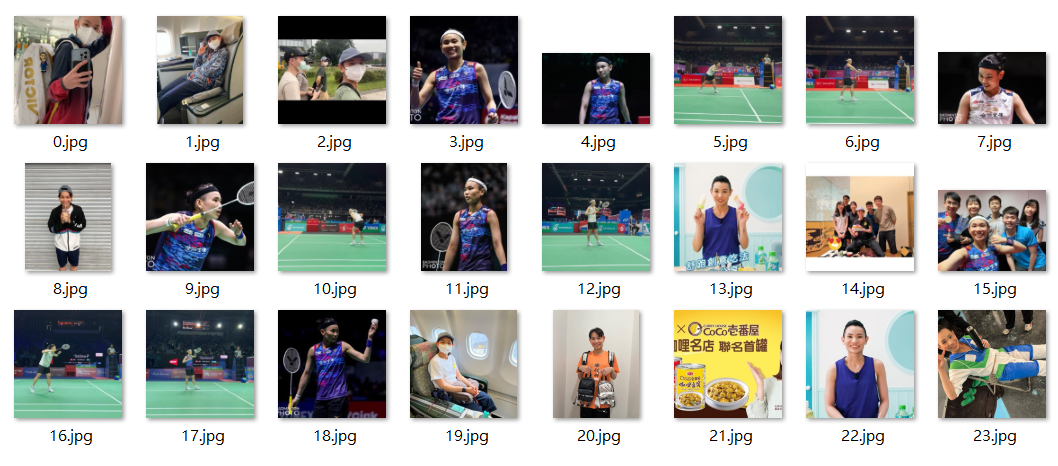

#PChome 爬取

##方法一

In [ ]:
from selenium.webdriver import Chrome
import time
import pyautogui
import pandas as pd
# 設定exe檔位置
driver = Chrome("C:\\Users\\user\\Desktop\\測試爬蟲\PC home\\chromedriver.exe")

# 設定要開啟的網頁
driver.get("https://shopping.pchome.com.tw/")

# 等待時間
time.sleep(2)

# 填寫關鍵字
driver.find_element_by_id("keyword").send_keys("asus筆電")
time.sleep(2)
# 點擊登入
driver.find_element_by_id('doSearch').click()
time.sleep(2)
#網頁向下
for j in range(20):
    time.sleep(0.5)
    pyautogui.press('pgdn')
# 抓取資料
from bs4 import BeautifulSoup
import requests

# BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')
#找標題
find_title = soup.find_all('h5','prod_name')
#print(find_title)
title_list = []
for i in find_title:
    title_list.append(i.text)
#找價格
price_list = []
find_price = soup.find_all('span','price')
#print(find_price)
for j in find_price:
    if len(j.text.replace('$','')) ==0:
        pass
    else:
        price_list.append(j.text.replace('$',''))
#找敘述
description_list = []
find_description =  soup.find_all('span','nick')
for k in find_description:
    description_list.append(k.text
                            
df = pd.DataFrame()
df['標題']=title_list
df['價格']=price_list
df['敘述']=description_list
df.to_csv('pchome.csv',index=False,encoding='utf-8-sig')

##獲得爬取結果

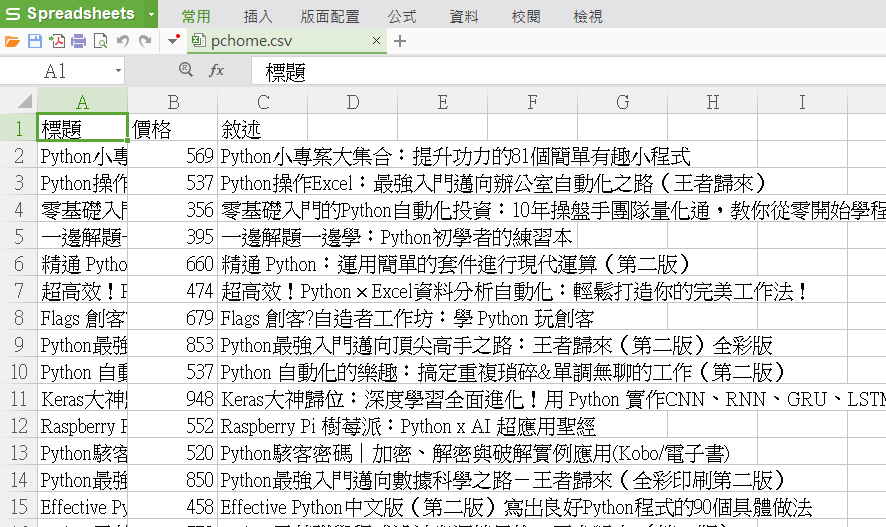

##方法二

In [ ]:
import requests
import json
import pandas as pd
import time

keyword = 'python'
# 要抓取的網址
url = 'https://ecshweb.pchome.com.tw/search/v3.3/all/results?q='+keyword+'&page=1&sort=sale/dc'


# https://24h.m.pchome.com.tw/prod/search/?q=python&show=list
#請求網站
list_req = requests.get(url)
#將整個網站的程式碼爬下來
getdata = json.loads(list_req.content)


# 蒐集多頁的資料，打包成csv檔案
alldata = pd.DataFrame() # 準備一個容器
for i in range(1,70):
    # 要抓取的網址
    url = 'https://ecshweb.pchome.com.tw/search/v3.3/all/results?q='+keyword+'&page='+str(i)+'&sort=sale/dc'
    #請求網站
    list_req = requests.get(url)
    #將整個網站的程式碼爬下來
    getdata = json.loads(list_req.content)
    todataFrame = pd.DataFrame(getdata['prods']) # 轉成Dataframe格式
    alldata = pd.concat([alldata, todataFrame]) # 將結果裝進容器
    
    time.sleep(5) #拖延時間
# 儲存檔案
alldata.to_csv('PChome6.csv', # 名稱
               encoding='utf-8-sig', # 編碼 
               index=False) # 是否保留Index

##獲得爬取結果

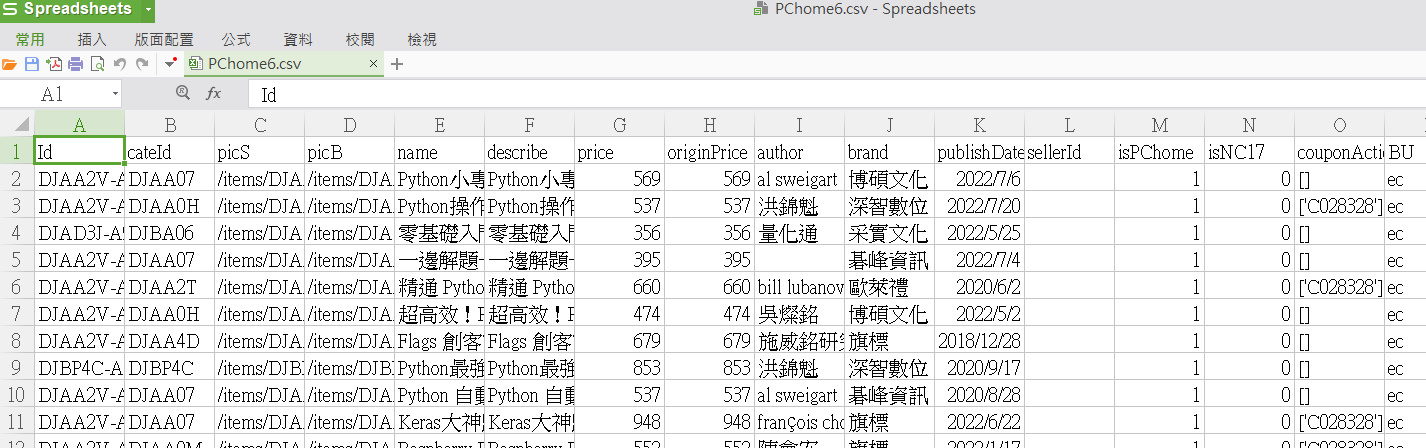